## TRAIN MODEL BASED ON ARRAYS

#### Import the relevant modules

In [112]:
import os
import cv2 as cv
import random
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [113]:
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, Conv2D, MaxPool2D, Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [114]:
ROOT = os.getcwd()
# PATH = ROOT + "/machine-learning/"
PATH = ROOT
TRAIN_PATH = PATH + "train"
TEST_PATH = PATH + "test"
IMG_SIZE = 70
input_shape = (IMG_SIZE, IMG_SIZE, 1)
print(f'PATH: {PATH}')

PATH: C:\Work\Projects\opencv-tanks\machine-learning


#### Get the categories

In [115]:
categories = []

with open(PATH + "/categories.txt", "r") as file:
    categories = file.read().splitlines()

num_classes = len(categories)
print(categories)
print(f'Number of classes: {num_classes}')

['stamp_1', 'stamp_2', 'stamp_p', 'stamp_t', 'stamp_1_180', 'stamp_2_180', 'stamp_p_180', 'stamp_t_180', 'stamp_1_90', 'stamp_2_90', 'stamp_p_90', 'stamp_t_90']
Number of classes: 12


#### Convert images to Arrays

In [116]:
dataset = []
i = 0

for folder in categories:
    files = os.listdir('../images/' + categories[i])
    for file in files:
        img = cv.imread('../images/' + categories[i] + "/" + file, 0)
        img = cv.resize(img, input_shape[:2])
        dataset.append([img, i])
    i += 1

random.shuffle(dataset)
print(f'Total Images: {len(dataset)}')

Total Images: 916


Label: stamp_p_90


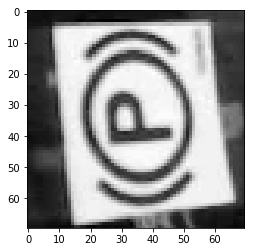

In [130]:
index = random.randint(0,len(dataset) - 1)
image = dataset[index][0]
label = categories[dataset[index][1]]
plt.imshow(image, cmap='gray')
print(f'Label: {label}')

#### Sort, shuffle, reshape, standardize and split data

In [122]:
X = []
y = []

for images, labels in dataset:
    X.append(images)
    y.append(labels)

X = np.array(X).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
y = np.array(y)

X = X / 255

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.15, random_state=42
)

y_cat_train = to_categorical(y_train, num_classes)
y_cat_test = to_categorical(y_test, num_classes)

#### Create the model

In [123]:
model = Sequential()

model.add(
    Conv2D(filters=32, kernel_size=(3, 3), input_shape=input_shape, activation="relu")
)
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(filters=64, kernel_size=(3, 3), activation="relu"))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(filters=128, kernel_size=(3, 3), activation="relu"))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dense(128, activation="relu"))
model.add(Dropout(0.25))
model.add(Dense(num_classes, activation="softmax"))

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

model.fit(X_train, y_cat_train, batch_size=10, epochs=10, validation_split=0.15)

Train on 661 samples, validate on 117 samples
Epoch 1/10
661/661 [==============================] - 9s 14ms/sample - loss: 2.4538 - acc: 0.1014 - val_loss: 2.4216 - val_acc: 0.1026
Epoch 2/10
661/661 [==============================] - 8s 12ms/sample - loss: 2.1131 - acc: 0.2693 - val_loss: 1.4163 - val_acc: 0.4872
Epoch 3/10
661/661 [==============================] - 7s 11ms/sample - loss: 1.1824 - acc: 0.5825 - val_loss: 0.5067 - val_acc: 0.8632
Epoch 4/10
661/661 [==============================] - 8s 12ms/sample - loss: 0.6044 - acc: 0.8094 - val_loss: 0.3879 - val_acc: 0.9060
Epoch 5/10
661/661 [==============================] - 9s 13ms/sample - loss: 0.3842 - acc: 0.8729 - val_loss: 0.3243 - val_acc: 0.8974
Epoch 6/10
420/661 [==================>...........] - ETA: 2s - loss: 0.2786 - acc: 0.9095

KeyboardInterrupt: 

#### Evaluate the model

In [86]:
loss, acc = model.evaluate(X_test, y_cat_test)

print("LOSS: {}, ACC: {}".format(loss, acc * 100))

pred = model.predict_classes(X_test)
print(classification_report(y_test, pred))


# with timestamp, acc and loss
now = datetime.now()
str_date = now.strftime("%Y-%m-%d_%H%M%S")
file_name = f"stamps_{str_date}.h5"

model.save(file_name)

print("DONE!")

138/138 [==============================] - 0s 2ms/sample - loss: 0.2767 - acc: 0.9058
LOSS: 0.27674823027590045, ACC: 90.57971239089966
             precision    recall  f1-score   support

          0       1.00      0.92      0.96        13
          1       0.93      0.82      0.87        17
          2       1.00      1.00      1.00         3
          3       0.75      0.75      0.75         4
          4       0.90      0.86      0.88        21
          5       0.79      0.92      0.85        12
          6       0.71      0.83      0.77         6
          7       0.75      0.75      0.75         4
          8       0.95      0.95      0.95        22
          9       0.85      1.00      0.92        11
         10       1.00      1.00      1.00        14
         11       1.00      0.91      0.95        11

avg / total       0.91      0.91      0.91       138

DONE!
